# 2.

## 2.1

In [1]:
import numpy as np
import h5py
from urllib.request import urlretrieve
import os
from utils.utils import plot_ann_performance, analyze_ann_method
from utils.index import *
from functools import partial

%load_ext autoreload
%autoreload 2

def get_ann_benchmark_data(dataset_name):
    if not os.path.exists(f"{dataset_name}.hdf5"):
        print(f"Dataset {dataset_name} is not cached; downloading now ...")
        urlretrieve(f"http://ann-benchmarks.com/{dataset_name}.hdf5", f"{dataset_name}.hdf5")
    hdf5_file = h5py.File(f"{dataset_name}.hdf5", "r")
    return np.array(hdf5_file['train']), np.array(hdf5_file['test'])

tr, tst = get_ann_benchmark_data('glove-25-angular')
dim = tr.shape[1]
tr.shape, tst.shape

((1183514, 25), (10000, 25))

### 1. минимальная скорость на возврат соседей равна `10 * flat_l2_qps` queries / sec `(один индекс для этого требования)`

#### hnsw

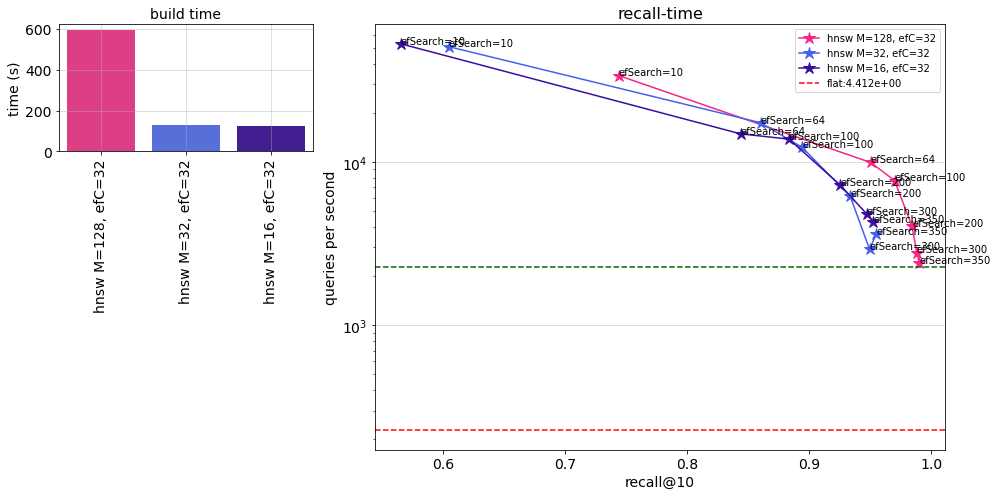

In [4]:
index_dict = {
    'hnsw M=128, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 128, 'ef_construction': 32},
        'build_func': build_hnsw,
        'search_param': ('efSearch', [10, 64, 100, 200, 300, 350]),
        'search_func': search_hnsw
    }, 
    'hnsw M=32, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 32, 'ef_construction': 32},
        'build_func': build_hnsw,
        'search_param': ('efSearch', [10, 64, 100, 200, 300, 350]),
        'search_func': search_hnsw
    }, 
    'hnsw M=16, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 16, 'ef_construction': 32},
        'build_func': build_hnsw,
        'search_param': ('efSearch', [10, 64, 100, 200, 300, 350]),
        'search_func': search_hnsw
    }, 
}


plot_ann_performance(
    build_data=tr,
    query_data=tst[:1000],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    qps_line=10,
)

looks like optimal M=64 since build time is huge for M=128

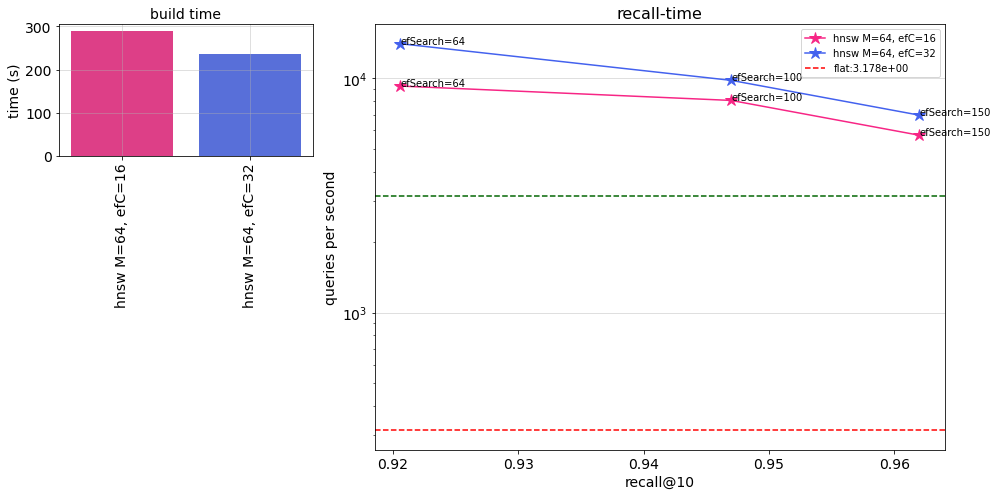

In [5]:
index_dict = {
    'hnsw M=64, efC=16': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 16},
        'build_func': build_hnsw,
        'search_param': ('efSearch', [64, 100, 150]), 
        'search_func': search_hnsw 
    }, 
    'hnsw M=64, efC=32': {
        'fixed_params': {'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 32},
        'build_func': build_hnsw,
        'search_param': ('efSearch', [64, 100, 150]),
        'search_func': search_hnsw 
    }, 
}

plot_ann_performance(
    build_data=tr,
    query_data=tst[:1000],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    qps_line=10,
)

we'll take M=64, efC=32 and efSearch=150+ then

#### IVFFlat

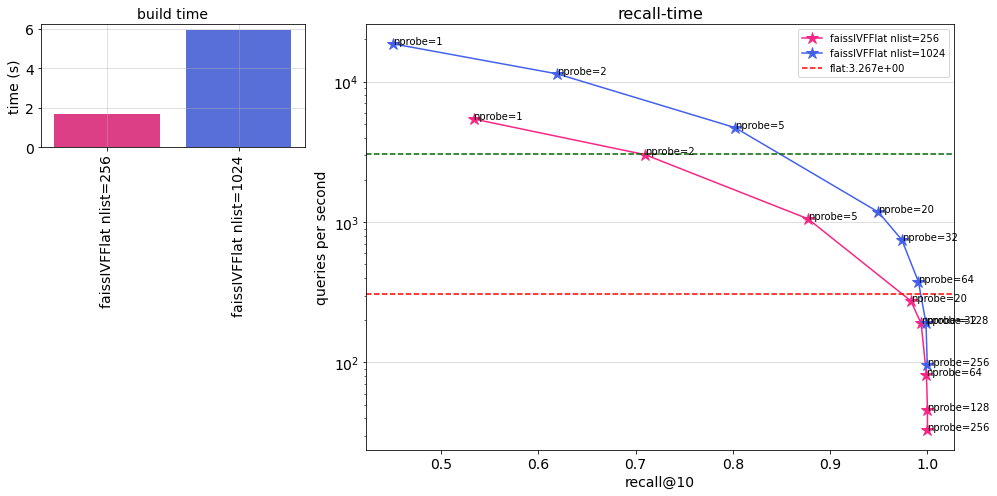

In [3]:
index_dict = {
    'faissIVFFlat nlist=256': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 256,
            'metric': faiss.METRIC_L2, # IP
            'num_threads': 1
        },
        'build_func': build_IVFFlat,
        'search_param': ('nprobe', [1, 2, 5, 20, 32, 64, 128, 256]),
        'search_func': search_faiss
    },
    'faissIVFFlat nlist=1024': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'nlist': 1024,
            'metric': faiss.METRIC_L2, # IP
            'num_threads': 1
        },
        'build_func': build_IVFFlat,
        'search_param': ('nprobe', [1, 2, 5, 20, 32, 64, 128, 256]),
        'search_func': search_faiss
    },
}


plot_ann_performance(
    build_data=tr,
    query_data=tst[:1000],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    qps_line=10,
    )

нет шансов в борьбе с hnsw, но зато не нужно ждать 100 часов результатов

#### IVFPQ

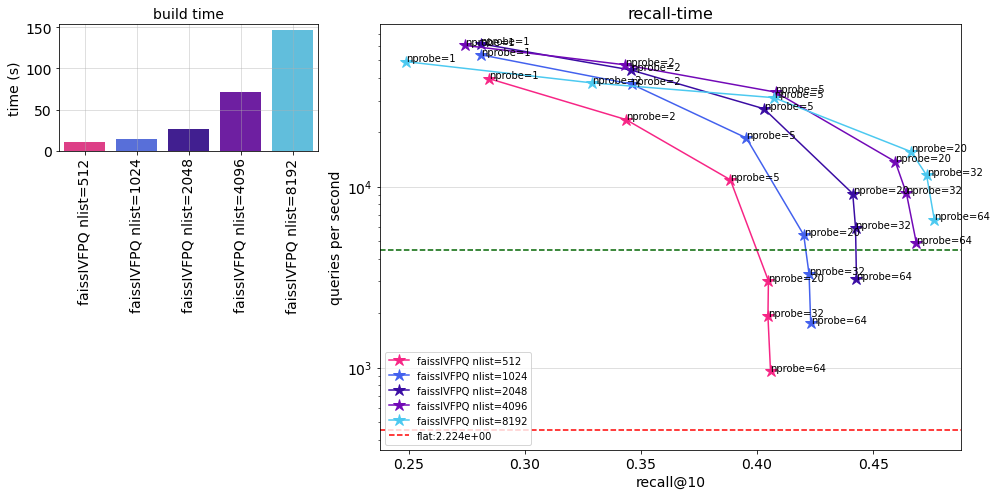

In [6]:
index_dict = {
    'faissIVFPQ nlist=512': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'm': 5,
            'nbits': 8,
            'nlist': 512,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('nprobe', [1, 2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
    'faissIVFPQ nlist=1024': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'm': 5,
            'nbits': 8,
            'nlist': 1024,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('nprobe', [1, 2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
    'faissIVFPQ nlist=2048': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'm': 5,
            'nbits': 8,
            'nlist': 2048,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('nprobe', [1, 2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
    'faissIVFPQ nlist=4096': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'm': 5,
            'nbits': 8,
            'nlist': 4096,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('nprobe', [1, 2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
    'faissIVFPQ nlist=8192': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'm': 5,
            'nbits': 8,
            'nlist': 8192,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('nprobe', [1, 2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
}


plot_ann_performance(
    build_data=tr,
    query_data=tst[:1000],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    qps_line=10,
    )

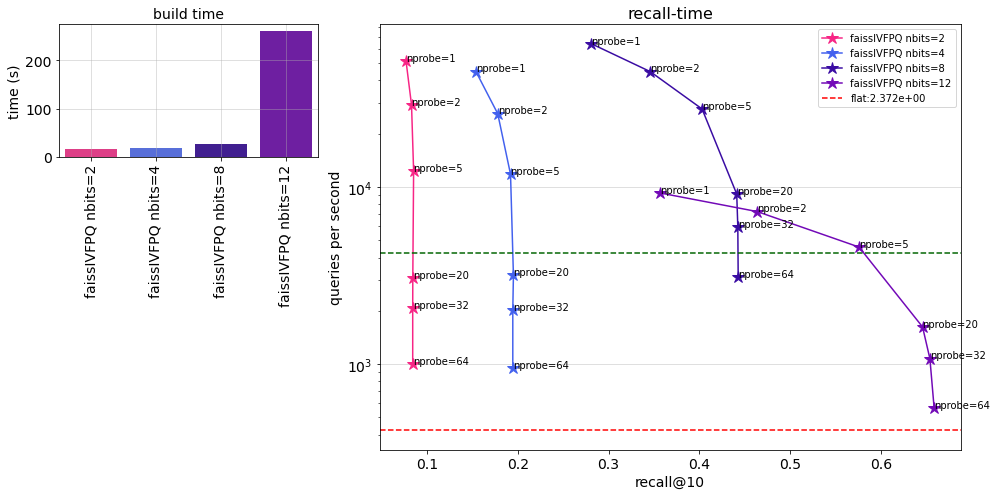

In [7]:
index_dict = {
  'faissIVFPQ nbits=2': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'm': 5,
            'nbits': 2,
            'nlist': 2048,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('nprobe', [1, 2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
    'faissIVFPQ nbits=4': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'm': 5,
            'nbits': 4,
            'nlist': 2048,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('nprobe', [1, 2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
    'faissIVFPQ nbits=8': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'm': 5,
            'nbits': 8,
            'nlist': 2048,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('nprobe', [1, 2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
    'faissIVFPQ nbits=12': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'm': 5,
            'nbits': 12,
            'nlist': 2048,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('nprobe', [1, 2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
}


plot_ann_performance(
    build_data=tr,
    query_data=tst[:1000],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    qps_line=10,
    )

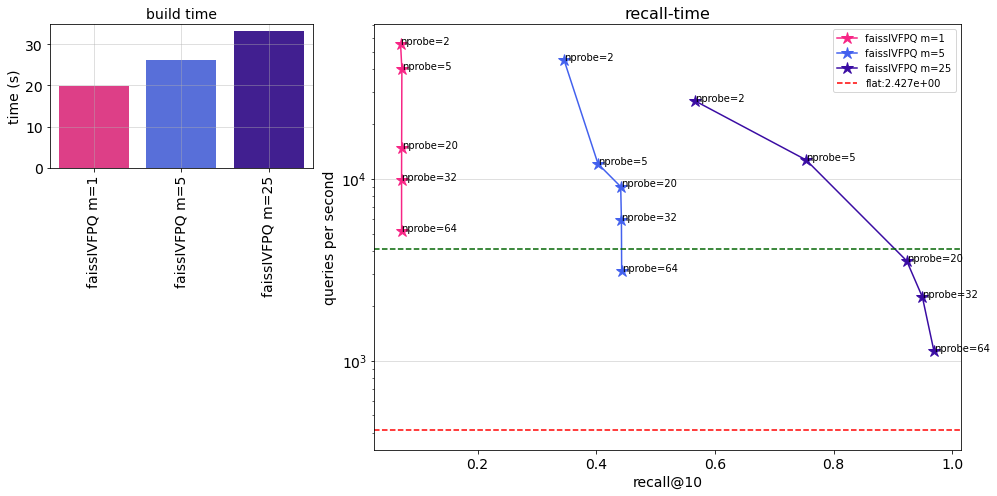

In [8]:
index_dict = {
  'faissIVFPQ m=1': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'm': 1,
            'nbits': 8,
            'nlist': 2048,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('nprobe', [2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
    'faissIVFPQ m=5': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'm': 5,
            'nbits': 8,
            'nlist': 2048,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('nprobe', [2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
    'faissIVFPQ m=25': {
        'fixed_params': {
            'dim': dim,
            'coarse_index': faiss.IndexFlatL2(dim),
            'm': 25,
            'nbits': 8,
            'nlist': 2048,
            'metric': faiss.METRIC_L2,
            'num_threads': 1
        },
        'build_func': build_IVFPQ,
        'search_param': ('nprobe', [2, 5, 20, 32, 64]),
        'search_func': search_faiss
    },
}


plot_ann_performance(
    build_data=tr,
    query_data=tst[:1000],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    qps_line=10,
    )

перебор гораздо сложнее, может быть, optuna в этом случае - хороший выход, но видно, что recall во всех случаях мал (при этом build time супер хороший), но hnsw тут лучше очевидно

### 2. получить максимальное качество соседей (все, что лучше recall@10=0.99 считаем за идеальное качество) `(и один индекс для этого требования)`

судя по предыдушим экспериментам, достаточно рассмотреть hnsw и IVFFlat.

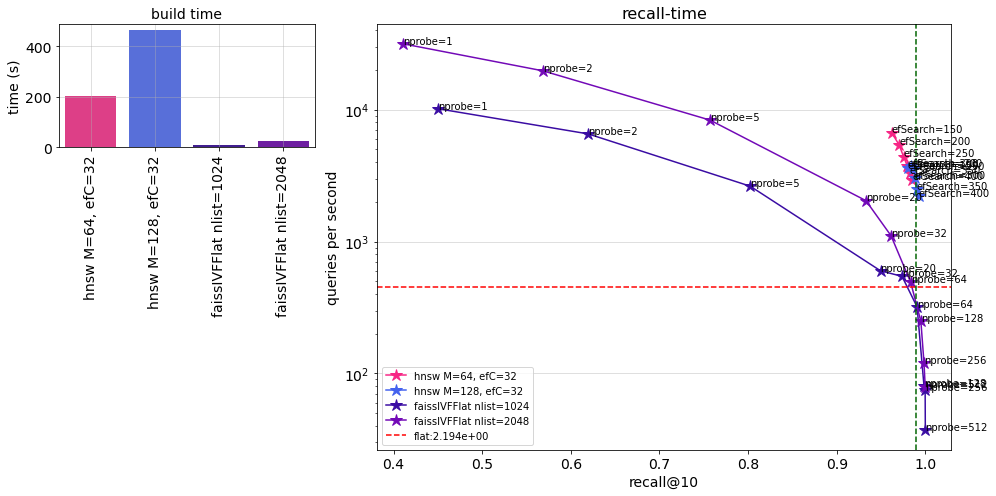

In [9]:
index_dict  = {
  'hnsw M=64, efC=32': {
    'fixed_params': {'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 32},
    'build_func': build_hnsw,
    'search_param': ('efSearch', [150, 200, 250, 300, 350, 400]),
    'search_func': search_hnsw
    }, 
  'hnsw M=128, efC=32': {
    'fixed_params': {'dim': dim, 'space': 'l2', 'M': 128, 'ef_construction': 32},
    'build_func': build_hnsw,
    'search_param': ('efSearch', [150, 200, 250, 300, 350, 400]),
    'search_func': search_hnsw 
    }, 
  'faissIVFFlat nlist=1024': {
    'fixed_params': {
      'dim': dim,
      'coarse_index': faiss.IndexFlatL2(dim),
      'nlist': 1024,
      'metric': faiss.METRIC_L2,
      'num_threads': 1
    },
    'build_func': build_IVFFlat,
    'search_param': ('nprobe', [1, 2, 5, 20, 32, 64, 128, 256, 512]),
    'search_func': search_faiss
    },
  'faissIVFFlat nlist=2048': {
    'fixed_params': {
      'dim': dim,
      'coarse_index': faiss.IndexFlatL2(dim),
      'nlist': 2048,
      'metric': faiss.METRIC_L2,
      'num_threads': 1
    },
    'build_func': build_IVFFlat,
    'search_param': ('nprobe', [1, 2, 5, 20, 32, 64, 128, 256, 512]),
    'search_func': search_faiss
    },
}


plot_ann_performance(
    build_data=tr,
    query_data=tst[:1000],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    recall_line=0.99,
    )


faissIVFFlat недотягивает, а hnsw, видимо, опять лучший (несмотря на долгий build time)

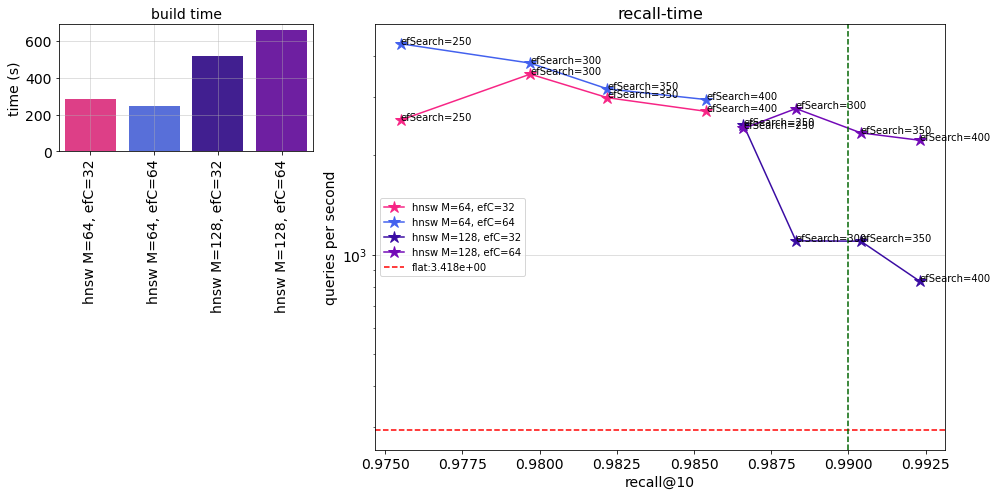

In [2]:
index_dict  = {
  'hnsw M=64, efC=32': {
    'fixed_params': {'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 32},
    'build_func': build_hnsw,
    'search_param': ('efSearch', [250, 300, 350, 400]),
    'search_func': search_hnsw
    }, 
  'hnsw M=64, efC=64': {
    'fixed_params': {'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 64},
    'build_func': build_hnsw,
    'search_param': ('efSearch', [250, 300, 350, 400]),
    'search_func': search_hnsw
    }, 
  'hnsw M=128, efC=32': {
    'fixed_params': {'dim': dim, 'space': 'l2', 'M': 128, 'ef_construction': 32},
    'build_func': build_hnsw,
    'search_param': ('efSearch', [250, 300, 350, 400]),
    'search_func': search_hnsw 
    }, 
  'hnsw M=128, efC=64': {
    'fixed_params': {'dim': dim, 'space': 'l2', 'M': 128, 'ef_construction': 64},
    'build_func': build_hnsw,
    'search_param': ('efSearch', [250, 300, 350, 400]),
    'search_func': search_hnsw 
    }, 
}


plot_ann_performance(
    build_data=tr,
    query_data=tst[:1000],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    recall_line=0.99,
    )


M = 128 брать нельзя по build time

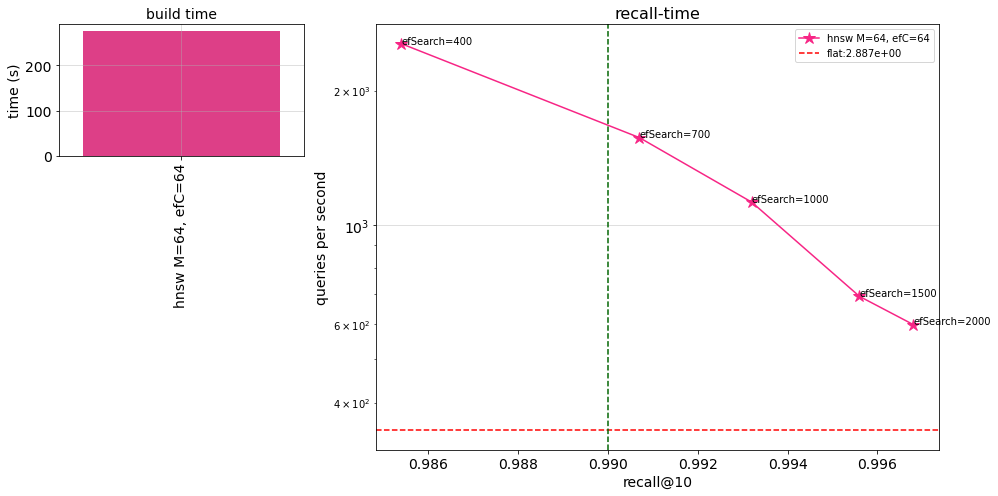

In [2]:
index_dict  = {
  'hnsw M=64, efC=64': {
    'fixed_params': {'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 64},
    'build_func': build_hnsw,
    'search_param': ('efSearch', [400, 700, 1000, 1500, 2000]),
    'search_func': search_hnsw
    }, 
}


plot_ann_performance(
    build_data=tr,
    query_data=tst[:1000],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    recall_line=0.99,
    )


## 2.2
посчитаем сколько надо нарисовать графиков для 20k, 50k, full. (#shape x cos/l2 x plot/analyse) $3*2*2=12$.. я опущу 50k чтобы не утонуть в графках (cos/l2 нельзя изображать на одном, ввиду различных build_flat, наша реализация это не позволит сделать, и не хочется переделывать)

In [3]:
tr, tst = get_ann_benchmark_data('nytimes-256-angular')
dim = tr.shape[1]
tr.shape, tst.shape

((290000, 256), (10000, 256))

### cosine

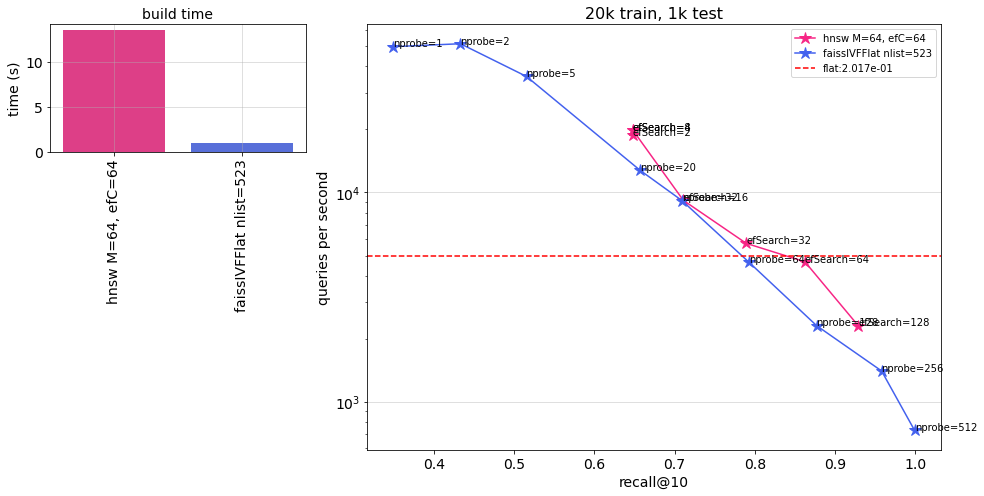

In [32]:
np.random.seed(911)
index_dict  = {
  'hnsw M=64, efC=64': {
    'fixed_params': {'dim': dim, 'space': 'cosine', 'M': 64, 'ef_construction': 64},
    'build_func': build_hnsw,
    'search_param': ('efSearch',  [2, 4, 8, 16, 32, 64, 128]),
    'search_func': search_hnsw 
    }, 
  'faissIVFFlat nlist=523': {
    'fixed_params': {
      'dim': dim,
      'coarse_index': faiss.IndexFlatL2(dim),
      'nlist': 512,
      'metric': 'cosine',
      'num_threads': 1
    },
    'build_func': build_IVFFlat,
    'search_param': ('nprobe', [1, 2, 5, 20, 32, 64, 128, 256, 512]),
    'search_func': search_faiss
    },
}

plot_ann_performance(
    build_data=tr[np.random.choice(tr.shape[0], 20000, replace=False)],
    query_data=tst[np.random.choice(tst.shape[0], 1000, replace=False)],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_cosine, dim=dim),
    flat_search_func=search_flat_cosine,
    query_in_train=False,
    title='20k train, 1k test',
    )

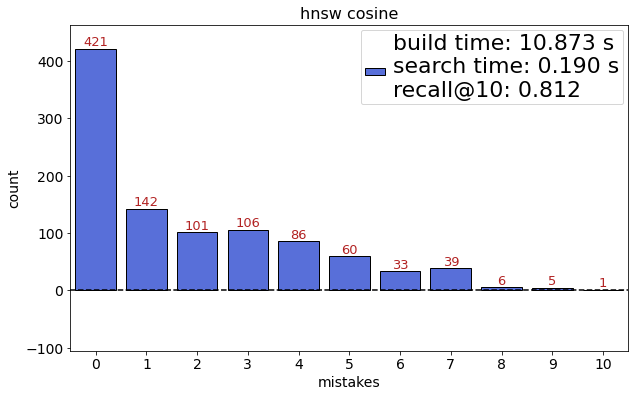

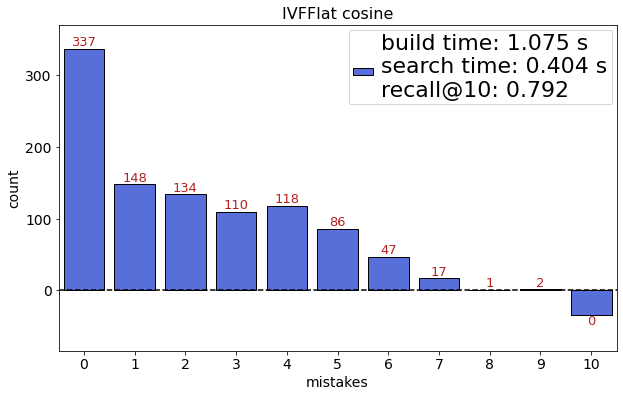

In [42]:
np.random.seed(911)
analyze_ann_method(
    build_data=tr[np.random.choice(tr.shape[0], 20000, replace=False)],
    query_data=tst[np.random.choice(tst.shape[0], 1000, replace=False)],
    build_func=partial(build_hnsw, **{'dim': dim, 'space': 'cosine', 'M': 64, 'ef_construction': 64}),
    search_func=partial(search_hnsw, efSearch=40),
    k=10,
    flat_build_func=partial(build_flat_cosine, dim=dim),
    flat_search_func=search_flat_cosine,
    query_in_train=False,
    index_name='hnsw cosine'
)

np.random.seed(911)
analyze_ann_method(
    build_data=tr[np.random.choice(tr.shape[0], 20000, replace=False)],
    query_data=tst[np.random.choice(tst.shape[0], 1000, replace=False)],
    build_func=partial(build_IVFFlat, **{'dim': dim, 'coarse_index': faiss.IndexFlatL2(dim),'nlist': 512, 'metric': 'cosine', 'num_threads': 1}),
    search_func=partial(search_faiss, nprobe=64, isCosine=True),
    k=10,
    flat_build_func=partial(build_flat_cosine, dim=dim),
    flat_search_func=search_flat_cosine,
    query_in_train=False,
    index_name='IVFFlat cosine'
)

теперь распределение на всей выборке:

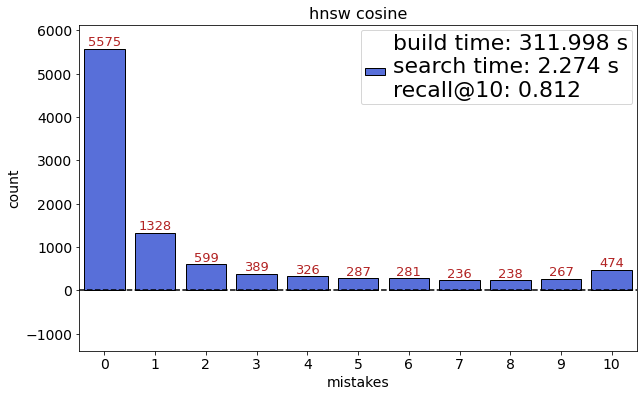

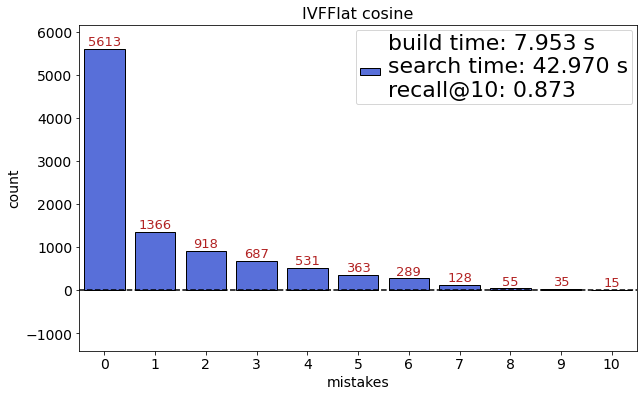

In [44]:
analyze_ann_method(
    build_data=tr,
    query_data=tst,
    build_func=partial(build_hnsw, **{'dim': dim, 'space': 'cosine', 'M': 64, 'ef_construction': 64}),
    search_func=partial(search_hnsw, efSearch=40),
    k=10,
    flat_build_func=partial(build_flat_cosine, dim=dim),
    flat_search_func=search_flat_cosine,
    query_in_train=False,
    index_name='hnsw cosine'
)

analyze_ann_method(
    build_data=tr,
    query_data=tst,
    build_func=partial(build_IVFFlat, **{'dim': dim, 'coarse_index': faiss.IndexFlatL2(dim),'nlist': 512, 'metric': 'cosine', 'num_threads': 1}),
    search_func=partial(search_faiss, nprobe=64, isCosine=True),
    k=10,
    flat_build_func=partial(build_flat_cosine, dim=dim),
    flat_search_func=search_flat_cosine,
    query_in_train=False,
    index_name='IVFFlat cosine'
)

### l2

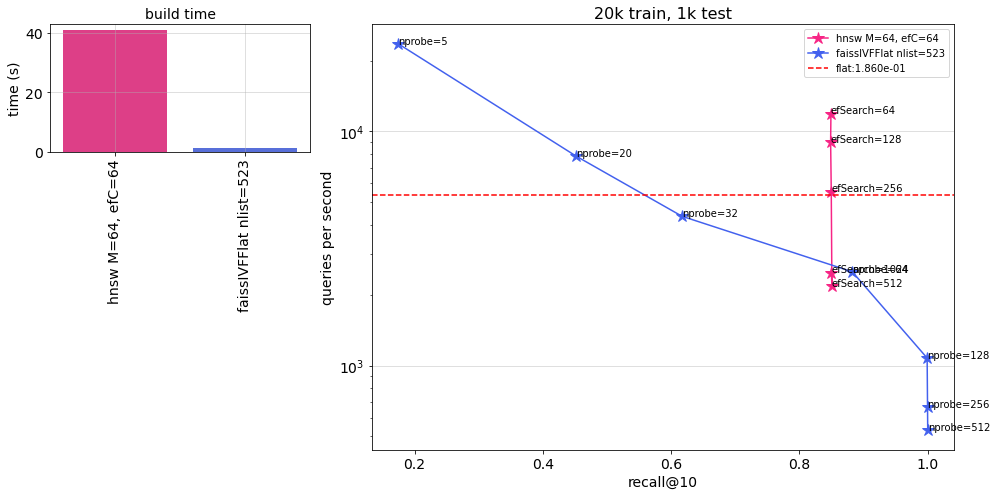

In [41]:
np.random.seed(911)
index_dict  = {
  'hnsw M=64, efC=64': {
    'fixed_params': {'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 64},
    'build_func': build_hnsw,
    'search_param': ('efSearch',  [64, 128, 256, 512, 1024]),
    'search_func': search_hnsw 
    }, 
  'faissIVFFlat nlist=523': {
    'fixed_params': {
      'dim': dim,
      'coarse_index': faiss.IndexFlatL2(dim),
      'nlist': 512,
      'metric': faiss.METRIC_L2,
      'num_threads': 1
    },
    'build_func': build_IVFFlat,
    'search_param': ('nprobe', [5, 20, 32, 64, 128, 256, 512]),
    'search_func': search_faiss
    },
}

plot_ann_performance(
    build_data=tr[np.random.choice(tr.shape[0], 20000, replace=False)],
    query_data=tst[np.random.choice(tst.shape[0], 1000, replace=False)],
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    title='20k train, 1k test',
    )

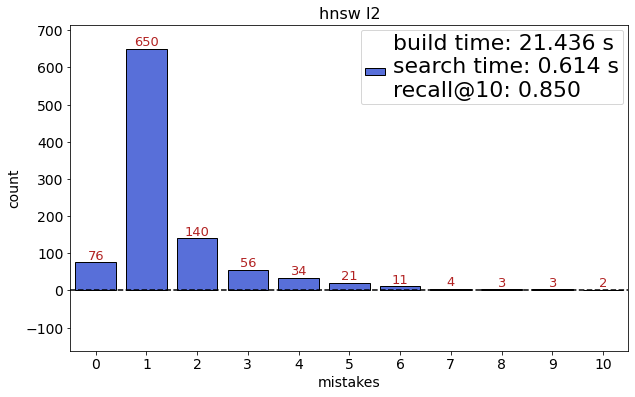

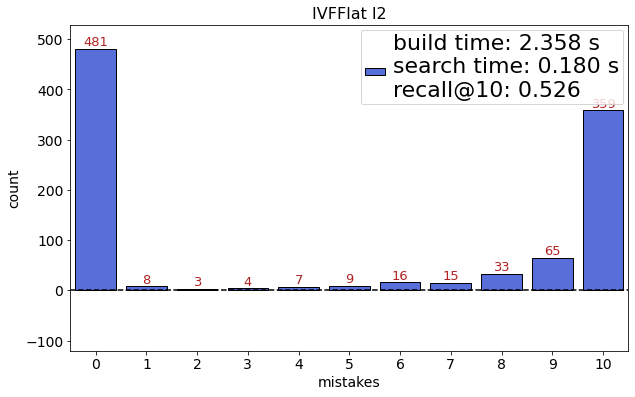

In [5]:
np.random.seed(911)
analyze_ann_method(
    build_data=tr[np.random.choice(tr.shape[0], 20000, replace=False)],
    query_data=tst[np.random.choice(tst.shape[0], 1000, replace=False)],
    build_func=partial(build_hnsw, **{'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 64}),
    search_func=partial(search_hnsw, efSearch=256),
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    index_name='hnsw l2'
)

np.random.seed(911)
analyze_ann_method(
    build_data=tr[np.random.choice(tr.shape[0], 20000, replace=False)],
    query_data=tst[np.random.choice(tst.shape[0], 1000, replace=False)],
    build_func=partial(build_IVFFlat, **{'dim': dim, 'coarse_index': faiss.IndexFlatL2(dim),'nlist': 512, 'metric': faiss.METRIC_L2, 'num_threads': 1}),
    search_func=partial(search_faiss, nprobe=25, isCosine=False),
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    index_name='IVFFlat l2'
)

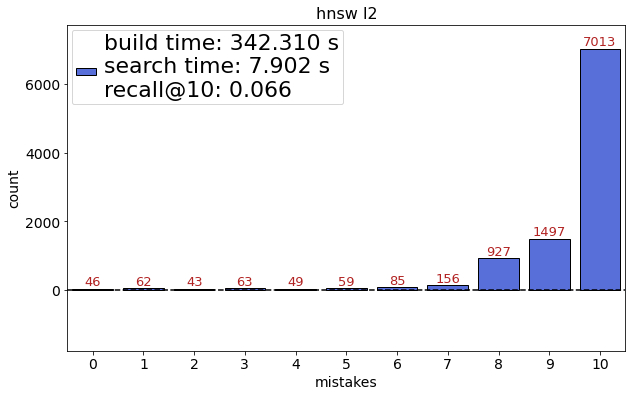

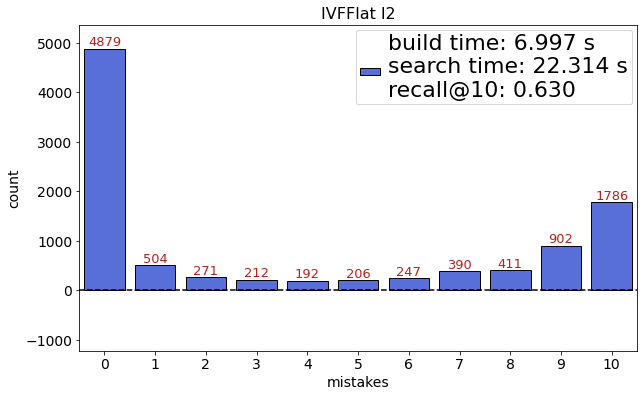

In [4]:
analyze_ann_method(
    build_data=tr,
    query_data=tst,
    build_func=partial(build_hnsw, **{'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 64}),
    search_func=partial(search_hnsw, efSearch=256),
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    index_name='hnsw l2'
)

analyze_ann_method(
    build_data=tr,
    query_data=tst,
    build_func=partial(build_IVFFlat, **{'dim': dim, 'coarse_index': faiss.IndexFlatL2(dim),'nlist': 512, 'metric': faiss.METRIC_L2, 'num_threads': 1}),
    search_func=partial(search_faiss, nprobe=25, isCosine=False),
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    index_name='IVFFlat l2'
)

hnsw умер

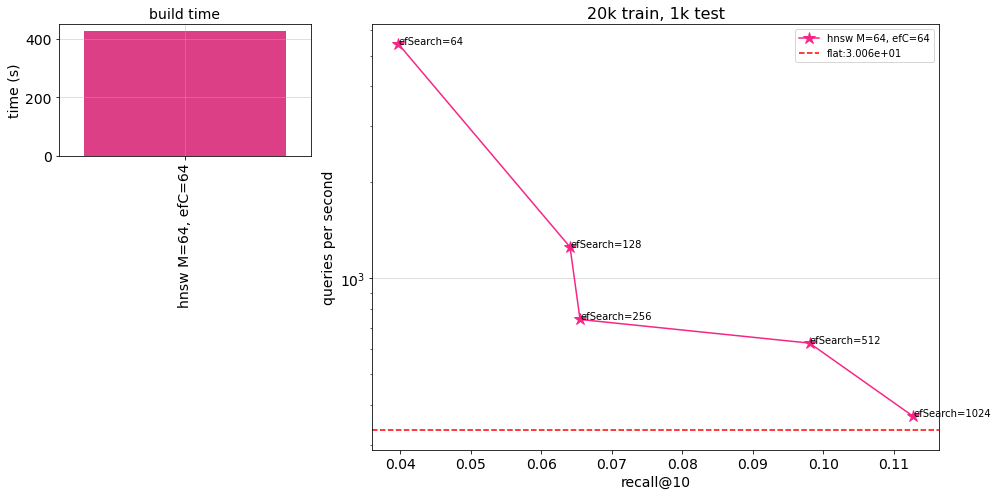

In [8]:
np.random.seed(911)
index_dict  = {
  'hnsw M=64, efC=64': {
    'fixed_params': {'dim': dim, 'space': 'l2', 'M': 64, 'ef_construction': 64},
    'build_func': build_hnsw,
    'search_param': ('efSearch',  [64, 128, 256, 512, 1024]),
    'search_func': search_hnsw 
    }, 
}

plot_ann_performance(
    build_data=tr,
    query_data=tst,
    index_dict=index_dict,
    k=10,
    flat_build_func=partial(build_flat_l2, dim=dim),
    flat_search_func=search_flat,
    query_in_train=False,
    title='20k train, 1k test',
    )

## 2.3

- no need